<a href="https://colab.research.google.com/github/maryam-sabet/Breast_Classification_and_Segmentation_ultrasoundimages/blob/main/3)breast_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Libraries**

In [ ]:
!pip install tensorflow==2.9.1

In [55]:
import glob
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import random
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,DenseNet121,Xception,EfficientNetV2B0
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input,Flatten,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint , CSVLogger , LearningRateScheduler
from sklearn.metrics import precision_score , recall_score , f1_score , confusion_matrix , ConfusionMatrixDisplay ,classification_report




# **Loading Data**

In [2]:
data = np.load("/content/drive/MyDrive/breast cancer/Pictures.npy",allow_pickle=True)
label = np.load("/content/drive/MyDrive/breast cancer/Label.npy",allow_pickle=True)

In [3]:
# Shuffle data
random.seed(1254)
combined = list(zip(data, label))
random.shuffle(combined)


data, label = zip(*combined)
label = np.array(label)
data = np.array(data)

In [4]:
class_label = np.unique(label , return_counts=True)
print(class_label)
class_label[1][0]

(array(['benign', 'malignant', 'normal'], dtype='<U9'), array([437, 210, 133]))


437

# **Preprosesing for build the model...**

In [5]:
#resize input images
Data =list()
for item in data:
  img = cv2.resize(item , (224,224) , cv2.INTER_NEAREST )
  Data.append(img)

Data = np.array(Data)

In [6]:
#train_test split
X_train, X_test, y_train, y_test = train_test_split(Data, label, test_size=0.05, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [7]:
print("Train" , X_train.shape, y_train.shape)
print("valid" , X_valid.shape, y_valid.shape)
print("Test",X_test.shape ,y_test.shape )

Train (666, 224, 224, 3) (666,)
valid (75, 224, 224, 3) (75,)
Test (39, 224, 224, 3) (39,)


In [8]:
#class weight for prevention of overfitting
class_label = np.unique(y_train, return_counts=True)
print(class_label)
N= float(len(data) / (2*class_label[1][0]))
M= float(len(data) / (2*class_label[1][1]))
B= float(len(data) / (2*class_label[1][2]))

print(N,M,N)
class_weight = {0:B , 1:M , 2:N}
print(f"class_weight is :{class_weight}")

(array(['benign', 'malignant', 'normal'], dtype='<U9'), array([370, 177, 119]))
1.054054054054054 2.2033898305084745 1.054054054054054
class_weight is :{0: 3.277310924369748, 1: 2.2033898305084745, 2: 1.054054054054054}


In [9]:
# Label binarizing
lb = preprocessing.LabelBinarizer()

y_train = lb.fit_transform(y_train)
print(y_train.shape)
y_valid = lb.fit_transform(y_valid)
print(y_valid.shape)
y_test = lb.fit_transform(y_test)
print(y_test.shape)

(666, 3)
(75, 3)
(39, 3)


# **Models**

In [66]:
# Define the model checkpoint to save model
model_save = ModelCheckpoint("/content/drive/MyDrive/breast cancer/save_breast_models/EfficientNetV2B0.h5" , save_best_only=True , verbose=2 , monitor="val_accuracy" , mode="max" )


In [67]:
base_model = EfficientNetV2B0(weights="imagenet", include_top=False , input_tensor=Input(shape=(224,224,3)))


# Build the custom classification head on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Flatten(name="flatting")(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

24274472/24274472 [==============================] - 0s 0us/step


# **preprocessing for fit model**

In [68]:
csv_loger = CSVLogger("/content/drive/MyDrive/breast cancer/save_breast_models/EfficientNetV2B0.csv" , append=True)

In [69]:
# Define a learning rate decay function
def set_decay(epoch):
  initAlpha =0.0008
  factor = 0.9
  dropEvery = 25
  aplpha = initAlpha * (factor**np.floor((1+epoch) / dropEvery))
  return float(aplpha)

# **Fit the model**

In [70]:
optim = keras.optimizers.Adam(learning_rate = 0.0008)
model.compile(optim , loss="categorical_crossentropy" , metrics=["accuracy"])


In [71]:
batch_size = 8
TrainStep = len(X_train) / batch_size
ValStep = len(X_valid) / batch_size

In [72]:
# generating with functions
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train = datagen.flow(X_train, y_train, batch_size=8)

In [73]:
H = model.fit(train , epochs=15, callbacks=[model_save, csv_loger, LearningRateScheduler(set_decay)]
                        , validation_data = (X_valid, y_valid),shuffle=True , steps_per_epoch= TrainStep , class_weight=class_weight)

Epoch 1/15
84/83 [==============================] - ETA: 0s - loss: 1.6904 - accuracy: 0.6486
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to /content/drive/MyDrive/breast cancer/save_breast_models/EfficientNetV2B0.h5
83/83 [==============================] - 30s 186ms/step - loss: 1.6904 - accuracy: 0.6486 - val_loss: 0.4531 - val_accuracy: 0.8000 - lr: 8.0000e-04
Epoch 2/15
84/83 [==============================] - ETA: 0s - loss: 1.2459 - accuracy: 0.7477
Epoch 2: val_accuracy did not improve from 0.80000
83/83 [==============================] - 10s 115ms/step - loss: 1.2459 - accuracy: 0.7477 - val_loss: 0.5083 - val_accuracy: 0.7867 - lr: 8.0000e-04
Epoch 3/15
84/83 [==============================] - ETA: 0s - loss: 1.2479 - accuracy: 0.7763
Epoch 3: val_accuracy improved from 0.80000 to 0.89333, saving model to /content/drive/MyDrive/breast cancer/save_breast_models/EfficientNetV2B0.h5
83/83 [==============================] - 14s 171ms/step - loss: 1.2479 - acc

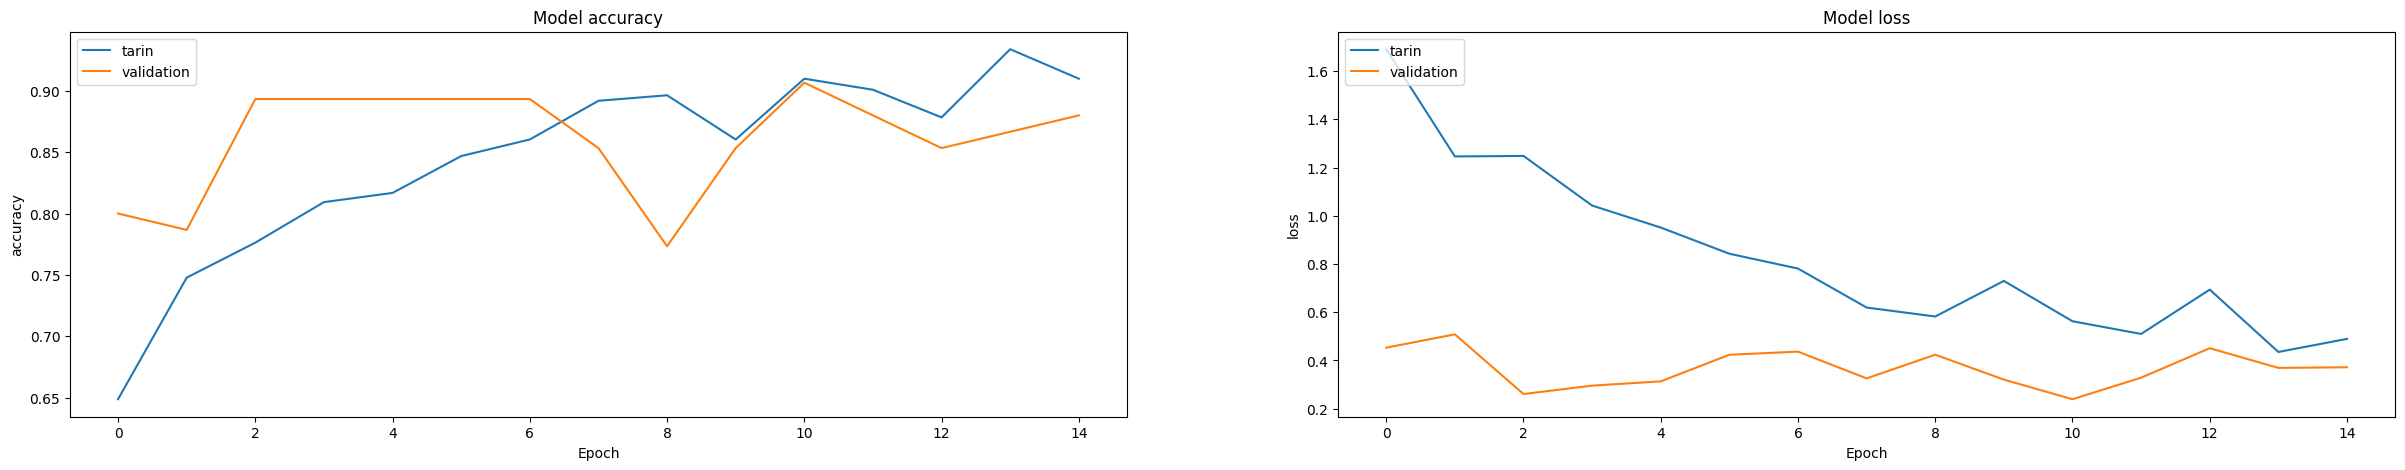

In [84]:
#show result
plt.figure(figsize=(30,5))
plt.subplot(121)
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(['tarin', "validation"] , loc="upper left")
plt.subplot(122)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(['tarin', "validation"] , loc="upper left")
plt.show()

# **Test Result**

In [75]:
model = tf.keras.models.load_model("/content/drive/MyDrive/breast cancer/save_breast_models/EfficientNetV2B0.h5")

In [77]:
#train
model.evaluate(X_train, y_train)

21/21 [==============================] - 5s 128ms/step - loss: 0.1025 - accuracy: 0.9580


[0.10253102332353592, 0.9579579830169678]

In [78]:
#test
model.evaluate(X_test, y_test)

2/2 [==============================] - 1s 582ms/step - loss: 0.4605 - accuracy: 0.8718


[0.46054908633232117, 0.8717948794364929]

In [79]:
prediction=model.predict(X_test)

2/2 [==============================] - 2s 57ms/step


In [87]:
#precision score
precision = precision_score(y_test , prediction ,  average="weighted")
print(precision*100)

87.32193732193733


In [89]:
#recal score
recal = recall_score(y_test , prediction  ,  average="weighted" )
print(recal*100)

87.17948717948718


In [90]:
#f1 score
f1 = f1_score(y_test , prediction ,  average="weighted")
print(f1*100)

87.12278712278714


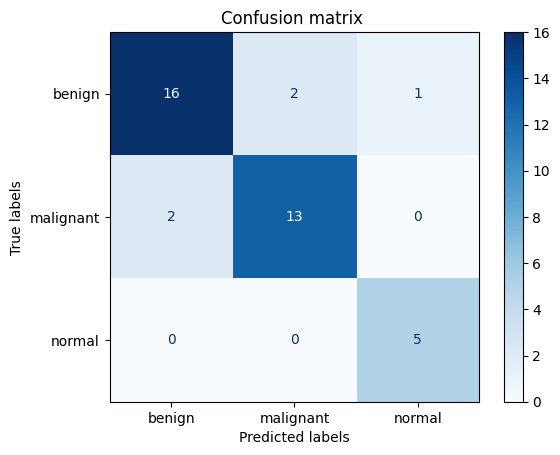

In [95]:
cm=confusion_matrix(y_test , prediction)
target_names = ["benign","malignant","normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.title('Confusion matrix ')
plt.ylabel("True labels")
plt.show()